In [1]:
import requests
import json
from datetime import date,timedelta, datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
import string
import re
!pip install gensim==4.2.0
from gensim.models.word2vec import Word2Vec

# For type hinting
from typing import List
import pandas as pd
import re
import numpy as np

def get_articles(end_date: str, query: str):  
  edate = datetime.fromisoformat(end_date)
  #edate = datetime.fromisoformat(input("input start the end date (from which you want to check last 7 days data) in yyyy-mm-dd format:",))
  #edate = date(2022,11,1)
  #sdate = date(2022,3,1)
  sdate = edate - timedelta(days=6)
  from_date = str(sdate.year)+'-'+str(sdate.month)+'-'+str(sdate.day)
  to_date = str(edate.year)+'-'+str(edate.month)+'-'+str(edate.day)


  r = requests.get('https://content.guardianapis.com/search?'
                    'q='+query+'&'
                    'from-date='+from_date+'&'
                    'to-date='+to_date+'&'
                    'show-section=true&'
                    'show-fields=body&'
                    'show-tags=all&'
                    'api-key=f13a5535-68ce-40c0-a1fe-39304e9770c3')
  res = r.json()
  article_content = []
  for i in tqdm(range(1,res['response']['pages']+1)):
    ri = requests.get('https://content.guardianapis.com/search?'
                  'q='+query+'&'
                  'from-date='+from_date+'&'
                  'to-date='+to_date+'&'
  #                'tag=world/china&'
                  'show-fields=body&'
                  'page='+str(i)+'&'
                  'show-section=true&'
                  'show-tags=all&'
                  'api-key=f13a5535-68ce-40c0-a1fe-39304e9770c3')
    temp = ri.json()
    if temp['response']['status']!='error':
      for article in temp['response']['results']:
        article_dict = {}
        art = article['fields']['body']
        soup = BeautifulSoup(art)
        temp_str = ''
        try:
          for para in soup.find_all('p'):
            temp_str += para.text + " "
          article_dict['content'] =temp_str
          article_dict['webTitle'] = article['webTitle']
          date = datetime.fromisoformat(article['webPublicationDate'].replace('T',' ').replace('Z',''))
          article_dict['date'] = date
          article_dict['tag'] = article['section']['webTitle']
          article_dict['date_weight'] = 1 #1/(edate.day - date.day)
          article_dict['subtag'] = article['tags'][0]['webTitle']
          article_dict['link'] = article['webUrl']
          article_dict['tag_list'] = [tag['webTitle'] for tag in article['tags']]
          article_content.append(article_dict)
        except KeyError:
          print('fail')
          pass
  return article_content

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 108.9 kB/s eta 0:00:00 kB/s eta 0:00:01


In [2]:
weights = {'Supply Chain':2,'Commodities':2,'Client Specific Words':5,'Automobile Indursty':4,'Suppliers':5,'War/ Calamities words':3}

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stemmer=nltk.stem.PorterStemmer()

def preprocessing(org_df:pd.DataFrame):
  articles = list(org_df['webTitle'] + org_df['content'])
  # stemming of articles
  
  for i in range(len(articles)):
    articles[i] = articles[i].lower()
    words=word_tokenize(articles[i])
    words=[stemmer.stem(word) for word in words if word not in stop_words]
    articles[i] = ' '.join(words)
  
  return articles

def check_for_bow(org_df:pd.DataFrame, bag_of_words_df:pd.DataFrame, articles:list):
  bagofwords_dict = {}
  # for i in list(bag_of_words_df['Supply Chain'].dropna()):
  #   if i not in stop_words:
  #     bagofwords_dict[stemmer.stem(i)] = 'Supply Chain'
  for i in list(bag_of_words_df['Commodities'].dropna()):
    if i not in stop_words:
      bagofwords_dict[stemmer.stem(i)] = 'Commodities'
  for i in list(bag_of_words_df['Client Specific Words'].dropna()):
    if i not in stop_words:
      bagofwords_dict[stemmer.stem(i)] = 'Client Specific Words'
  for i in list(bag_of_words_df['Automobile Indursty'].dropna()):
    if i not in stop_words:
      bagofwords_dict[stemmer.stem(i)] = 'Automobile Indursty'
  for i in list(bag_of_words_df['Suppliers'].dropna()):
    if i not in stop_words:
      bagofwords_dict[stemmer.stem(i)] = 'Suppliers'
  for i in list(bag_of_words_df['War/ Calamities words'].dropna()):
    if i not in stop_words:
      bagofwords_dict[stemmer.stem(i)] = 'War/ Calamities words'

  bagofwords = bagofwords_dict.keys()

  #filtering process needs improvement; highlight the keyword found in each article = print("\033[44;33mHello World!\033[m")

  df_article_bow = pd.DataFrame(columns=['article','keywords','category'])
  filtered_articles_index = []
  for i in tqdm(range(len(articles))):
    temp = []
    categ = []
    for word in bagofwords:
      for art_word in articles[i].split():
        if word == art_word:
          temp.append(word)
          articles[i] = re.sub(r'\b{}\b'.format(word), word.upper(), articles[i])
          categ.append(bagofwords_dict[word])
          
    df_article_bow.loc[len(df_article_bow)]= [articles[i],temp, categ]

  df_article_bow['keywords_length']=df_article_bow['keywords'].str.len()
  temp = org_df[df_article_bow['keywords_length']!=0]
  df_article_bow = df_article_bow[df_article_bow['keywords_length']!=0] 
  df_article_bow = df_article_bow.drop('article',axis=1)

  return temp.join(df_article_bow), bagofwords, bagofwords_dict

[nltk_data] Downloading package stopwords to /home/mohit/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/mohit/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Textblob model

In [6]:
#!pip install spacy
import spacy
nlp = spacy.load('en_core_web_sm')
from textblob import TextBlob

def textblob_sentiment(df_article_bow:pd.DataFrame, bagofwords:list, bagofwords_dict:dict):  
  article_sentiment = []
  for text in tqdm(list(df_article_bow['webTitle']+df_article_bow['content'])):
    clean_text= text.replace("/", " ")       
    clean_text= ''.join([c for c in clean_text if c != "'"])

    sentence=[]
    tokens = nlp(clean_text)
    for sent in tokens.sents:
        sentence.append((sent.text.strip()))


    textblob_sentiment=[]
    for s in sentence:
        cat_score = 1
        categ = []
        txt= TextBlob(s)
        a= txt.sentiment.polarity
        b= txt.sentiment.subjectivity

        for word in bagofwords:
          for art_word in s.split():
            if word == stemmer.stem(art_word):
              categ.append(bagofwords_dict[word])
              cat_score += weights[bagofwords_dict[word]]
        textblob_sentiment.append([s,a,b,categ,cat_score])

    df_textblob = pd.DataFrame(textblob_sentiment, columns =['Sentence', 'Polarity', 'Subjectivity','category','category_score'])
    #df_textblob=df_textblob.replace(0.0,np.nan).dropna()
    pol = sum(df_textblob['Polarity']*df_textblob['category_score'])/sum(df_textblob['category_score'])
    sub = sum(df_textblob['Subjectivity']*df_textblob['category_score'])/sum(df_textblob['category_score'])
    article_sentiment.append([pol,sub])

  textblob_article_sentiment = pd.DataFrame(article_sentiment,columns=['weighted_average_polarity','weighted_average_subjectivity'])
  df_article_bow['textblob_weighted_average_polarity'] = list(textblob_article_sentiment['weighted_average_polarity'])
  df_article_bow['textblob_weighted_average_subjectivity'] = list(textblob_article_sentiment['weighted_average_subjectivity'])

  return df_article_bow

In [5]:
#!python3 -m spacy download en_core_web_sm

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.4 kB/s eta 0:00:00m eta 0:00:010:00:04
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## Vader Model

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def vader_sentiment(df_article_bow:pd.DataFrame, bagofwords:list, bagofwords_dict:dict):  
  vader_art_sent = []
  for text in tqdm(list(df_article_bow['webTitle']+df_article_bow['content'])):
    clean_text= text.replace("/", " ")       
    clean_text= ''.join([c for c in clean_text if c != "'"])
    sentence=[]
    tokens = nlp(clean_text)
    for sent in tokens.sents:
        sentence.append((sent.text.strip()))

  #optimize: use the previously created column where we have category of each article, check only on that category of bag of words
    vader_sentiment=[]
    for s in sentence:
        categ = []
        cat_score = 1
        txt= sid.polarity_scores(s)
        for word in bagofwords:
          for art_word in s.split():
            if word == stemmer.stem(art_word):
              categ.append(bagofwords_dict[word])
              cat_score += weights[bagofwords_dict[word]]
        
        vader_sentiment.append([s,txt['compound'],txt['neg'],txt['neu'],txt['pos'],categ,cat_score])

    df_vader = pd.DataFrame(vader_sentiment, columns =['Sentence','compound', 'neg', 'neu','pos','category','category_score'])
    #df_vader=df_vader.replace(0.0,np.nan).dropna()
    comp = sum(df_vader['compound']*df_vader['category_score'])/sum(df_vader['category_score'])
    neg = sum(df_vader['neg']*df_vader['category_score'])/sum(df_vader['category_score'])
    neu = sum(df_vader['neu']*df_vader['category_score'])/sum(df_vader['category_score'])
    pos = sum(df_vader['pos']*df_vader['category_score'])/sum(df_vader['category_score'])
    vader_art_sent.append([comp,neg,neu,pos])

  vader_article_sentiment = pd.DataFrame(vader_art_sent,columns=['weighted_average_compound','weighted_average_negativity','weighted_average_nutrality','weighted_average_positivity'])
  df_article_bow['vader_weighted_average_compound'] = list(vader_article_sentiment['weighted_average_compound'])
  df_article_bow['vader_weighted_average_negativity'] = list(vader_article_sentiment['weighted_average_negativity'])
  df_article_bow['vader_weighted_average_nutrality'] = list(vader_article_sentiment['weighted_average_nutrality'])
  df_article_bow['vader_weighted_average_positivity'] = list(vader_article_sentiment['weighted_average_positivity'])

  return df_article_bow


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/mohit/nltk_data...


## Word2vec model

In [8]:

class Tokenizer: 
    # initialization method to create the default instance constructor for the class
    def __init__(self,
                 clean: bool = True,
                 lower: bool = True, 
                 de_noise: bool = True, 
                 remove_stop_words: bool = True,
                keep_negation: bool = True) -> List[str]:
      
        self.de_noise = de_noise
        self.remove_stop_words = remove_stop_words
        self.clean = clean
        self.lower = lower
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.keep_negation = keep_negation

    # other methods  
    def denoise(self, text: str) -> str:
        """
        Removing html and URL components
        """
        html_pattern = r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"
        url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"

        text = re.sub(html_pattern, " ", text)
        text = re.sub(url_pattern," ",text).strip()
        return text
       
    
    def remove_stopwords(self, tokenized_text: List[str]) -> List[str]:
        text = [word for word in tokenized_text if word not in self.stopwords]
        return text

    
    def keep_negation_sw(self, text: str) -> str:
        """
        A function to save negation words (n't, not, no) from removing as stopwords
        """
        # to replace "n't" with "not"
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"n\'t", " not", text)
        # to join not/no into the next word
        text = re.sub("not ", " NOT", text)
        text = re.sub("no ", " NO", text)
        return text
    
    
    def tokenize(self, text: str) -> List[str]:
        """
        A function to tokenize words of the text
        """
        non_alphanumeric_pattern =r"[^a-zA-Z0-9]"
        
        # to substitute multiple whitespace with single whitespace
        text = ' '.join(text.split())

        if self.de_noise:
            text = self.denoise(text)
        if self.lower:
            text = text.lower()
        if self.keep_negation:
            text = self.keep_negation_sw(text)
            
        if self.clean:
            # to remove non-alphanumeric characters
            text = re.sub(non_alphanumeric_pattern," ", text).strip()

        tokenized_text = text.split()

        if self.remove_stop_words:
            tokenized_text = self.remove_stopwords(tokenized_text)

        return tokenized_text

def w2v_trainer(doc_tokens: List[str],
                epochs: int = 10,
                workers: int = 3,
                vector_size: int = 300,
                window: int = 5,
                min_count: int = 2):

    w2v_model = Word2Vec(doc_tokens,
                         epochs=10,
                         workers=3,
                         vector_size=300,
                         window=5,
                         min_count=2)
    
    # create objects to store keyed vectors and keyed vocabs
    keyed_vectors = w2v_model.wv
    keyed_vocab = keyed_vectors.key_to_index
    
    return keyed_vectors, keyed_vocab
  
def calculate_overall_similarity_score(keyed_vectors,
                             target_tokens: List[str], 
                             doc_tokens: List[str]) -> float:
    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]

    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    
    similarity_score = keyed_vectors.n_similarity(target_tokens, doc_tokens)
    
    return similarity_score
def overall_semantic_sentiment_analysis (keyed_vectors, 
                                         positive_target_tokens: List[str],
                                         negative_target_tokens: List[str],
                                         doc_tokens: List[str], 
                                         doc_is_series: bool = True) -> float:

  
    positive_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x))

    negative_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x))

    semantic_sentiment_score = positive_score - negative_score
    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity
def list_similarity(keyed_vectors, 
                    wordlist1: List[str], 
                    wordlist2: List[str]) -> pd.Series:
    """ A function to calculate vector similarity between 2 lists of tokens"""
    wv1= np.array([keyed_vectors[wd] for wd in wordlist1 if wd in keyed_vectors])
    wv2= np.array([keyed_vectors[wd] for wd in wordlist2 if wd in keyed_vectors])
    wv1 /= np.linalg.norm(wv1, axis=1)[:, np.newaxis]
    wv2 /= np.linalg.norm(wv2, axis=1)[:, np.newaxis]

    return np.dot(wv1, np.transpose(wv2))
    

def calculate_topn_similarity_score(keyed_vectors, 
                          target_tokens: List[str], 
                          doc_tokens: List[str],
                          topn: int = 10) -> float:

    topn = min(topn, round(len(doc_tokens)))
    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]

    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    
    sim_matrix = list_similarity(keyed_vectors=keyed_vectors, 
                                 wordlist1=target_tokens,
                                 wordlist2=doc_tokens)
    sim_matrix = np.sort(sim_matrix, axis=1)[:, -topn:]
     
    similarity_score = np.mean(sim_matrix)
    
    return similarity_score




def topn_semantic_sentiment_analysis(keyed_vectors, 
                                      positive_target_tokens: List[str],
                                      negative_target_tokens: List[str],
                                      doc_tokens: List[str],
                                      topn: int = 10) -> float:

  
    positive_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                      
    negative_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                           
    semantic_sentiment_score = positive_score - negative_score
    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity


In [9]:

def word2vec_sentiment(df_article_bow:pd.DataFrame):
  tokenizer = Tokenizer(clean= True,
                        lower= True, 
                        de_noise= True, 
                        remove_stop_words= True,
                        keep_negation=True)
  temp_articles =  df_article_bow[['content','webTitle']]
  temp_articles['tokenized_text'] = temp_articles['content'].apply(tokenizer.tokenize)

  temp_articles['tokenized_text_len'] = temp_articles['tokenized_text'].apply(len)
  keyed_vectors, keyed_vocab = w2v_trainer(temp_articles['tokenized_text'])
  positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
  pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]

  negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
  neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]
  overall_df_scores = overall_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                    positive_target_tokens = pos_concepts, 
                                                    negative_target_tokens = neg_concepts,
                                                    doc_tokens = temp_articles['tokenized_text'])

  # Calculating Semantic Sentiment Scores by TopSSA model
  topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                    positive_target_tokens = pos_concepts, 
                                                    negative_target_tokens = neg_concepts,
                                                    doc_tokens = temp_articles['tokenized_text'],
                                                      topn=30)


  # To store semantic sentiment store computed by OSSA model in df
  df_article_bow['w2v_overall_PSS'] = overall_df_scores[0] 
  df_article_bow['w2v_overall_NSS'] = overall_df_scores[1] 
  df_article_bow['w2v_overall_semantic_sentiment_score'] = overall_df_scores[2] 
  df_article_bow['w2v_overall_semantic_sentiment_polarity'] = overall_df_scores[3]



  # To store semantic sentiment store computed by TopSSA model in df
  df_article_bow['w2v_topn_PSS'] = topn_df_scores[0] 
  df_article_bow['w2v_topn_NSS'] = topn_df_scores[1] 
  df_article_bow['w2v_topn_semantic_sentiment_score'] = topn_df_scores[2] 
  df_article_bow['w2v_topn_semantic_sentiment_polarity'] = topn_df_scores[3]

  return df_article_bow



In [12]:
with open('report.txt','w+') as fp:
  for da in range(11,4,-1):
    article_content = get_articles("2022-06-"+str(da),"China")
    df_article = pd.DataFrame(article_content)
    fp.write("======================================================\n")
    fp.write("Date = 2022-06-"+str(da)+"\n")
    fp.write("the lenght of df_article= "+str(len(df_article))+"\n")

    df_tag_article = df_article[df_article['subtag']=="China"]

    selection = ['China']
    df_subtag_article = df_article[df_article.tag_list.apply(lambda x: any(item for item in selection if item in x))]

    bag_of_words_df = pd.read_csv("Bag_of_words_supply_chain - Sheet3.csv")
    articles = preprocessing(df_article)
    df_article_bow, bagofwords, bagofwords_dict = check_for_bow(df_article, bag_of_words_df, articles)
    fp.write("the lenght of df_article_bow= "+str(len(df_article_bow))+"\n")

    textblob_sentiments = textblob_sentiment(df_article_bow, bagofwords, bagofwords_dict)
    vader_sentiments = vader_sentiment(df_article_bow, bagofwords, bagofwords_dict)
    word2vec_sentiments = word2vec_sentiment(df_article_bow)
    
    fp.write("the lenght of df_tag_article= "+str(len(df_tag_article))+"\n")
    temp = list(df_tag_article.index)
    for i in temp:
      if i not in df_article_bow.index:
        df_tag_article = df_tag_article.drop(i,axis=0)
    df_tag_article = df_article_bow.loc[list(df_tag_article.index),:]
    fp.write("the lenght of df_tag_article_bow= "+str(len(df_tag_article))+"\n")
    fp.write("the lenght of df_subtag_article= "+str(len(df_subtag_article))+"\n")
    temp = list(df_subtag_article.index)
    for i in temp:
      if i not in df_article_bow.index:
        df_subtag_article = df_subtag_article.drop(i,axis=0)

    df_subtag_article = df_article_bow.loc[list(df_subtag_article.index),:]
    fp.write("the lenght of df_subtag_article_bow= "+str(len(df_subtag_article))+"\n")


    word2vec_sentiments.to_csv('sentiments_'+str(da)+'_query.csv')
    df_tag_article.to_csv('sentiments_'+str(da)+'_tag.csv')
    df_subtag_article.to_csv('sentiments_'+str(da)+'_subtag.csv')


100%|███████████████████████████████████████████| 81/81 [11:14<00:00,  8.32s/it]
/tmp/ipykernel_34715/2970304014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_articles['tokenized_text'] = temp_articles['content'].apply(tokenizer.tokenize)
/tmp/ipykernel_34715/2970304014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_articles['tokenized_text_len'] = temp_articles['tokenized_text'].apply(len)
100%|███████████████████████████████████████████| 76/76 [10:18<00:00,  8.13s/it]
/tmp/ipykernel_

ValueError: Invalid isoformat string: '2022-06-9'

In [110]:
import pandas as pd
import numpy as np
for da in range(11,4,-1):
    print("==================================================\n")
    print('FOR DATE: '+str(da))
    query_df = pd.read_csv("sentiments_"+str(da)+"_query.csv")
    tag_df = pd.read_csv("sentiments_"+str(da)+"_tag.csv")
    subtag_df = pd.read_csv("sentiments_"+str(da)+"_subtag.csv")
    query_df['textblob_sentiment'] = np.where(query_df['textblob_weighted_average_polarity']>0,1,0)
    query_df['vader_sentiment'] = np.where(query_df['vader_weighted_average_positivity']>query_df['vader_weighted_average_negativity'],1,0)

    tag_df['textblob_sentiment'] = np.where(tag_df['textblob_weighted_average_polarity']>0,1,0)
    tag_df['vader_sentiment'] = np.where(tag_df['vader_weighted_average_positivity']>tag_df['vader_weighted_average_negativity'],1,0)

    subtag_df['textblob_sentiment'] = np.where(subtag_df['textblob_weighted_average_polarity']>0,1,0)
    subtag_df['vader_sentiment'] = np.where(subtag_df['vader_weighted_average_positivity']>subtag_df['vader_weighted_average_negativity'],1,0)
    print("\nFor Query_df \n")
    print("Textblob\n")
    print(query_df['textblob_sentiment'].value_counts())
    print("\nVader\n")
    print(query_df['vader_sentiment'].value_counts())
    print("\nW2v overall\n")
    print(query_df['w2v_overall_semantic_sentiment_polarity'].value_counts())
    print("\nw2v topn\n")
    print(query_df['w2v_topn_semantic_sentiment_polarity'].value_counts())
    
    print("\nFor tag \n")
    print("Textblob\n")
    print(tag_df['textblob_sentiment'].value_counts())
    print("\nVader\n")
    print(tag_df['vader_sentiment'].value_counts())
    print("\nW2v overall\n")
    print(tag_df['w2v_overall_semantic_sentiment_polarity'].value_counts())
    print("\nw2v topn\n")
    print(tag_df['w2v_topn_semantic_sentiment_polarity'].value_counts())
    
    print("\nFor sub tag \n")
    print("Textblob\n")
    print(subtag_df['textblob_sentiment'].value_counts())
    print("\nVader\n")
    print(subtag_df['vader_sentiment'].value_counts())
    print("\nW2v overall\n")
    print(subtag_df['w2v_overall_semantic_sentiment_polarity'].value_counts())
    print("\nw2v topn\n")
    print(subtag_df['w2v_topn_semantic_sentiment_polarity'].value_counts())
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in query_df.index:
#       if query_df['textblob_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(query_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in query_df.index:
#       if query_df['vader_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(query_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in query_df.index:
#       if query_df['w2v_overall_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(query_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in query_df.index:
#       if query_df['w2v_topn_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(query_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     print("\n====================For Tag list========================\n")
#     #For tag list
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in tag_df.index:
#       if tag_df['textblob_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(tag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in tag_df.index:
#       if tag_df['vader_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(tag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in tag_df.index:
#       if tag_df['w2v_overall_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(tag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in tag_df.index:
#       if tag_df['w2v_topn_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(tag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
#     print("\n======================For Subtag==================\n")

#     #Subtag list

#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in subtag_df.index:
#       if subtag_df['textblob_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(subtag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in subtag_df.index:
#       if subtag_df['vader_sentiment'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(subtag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in subtag_df.index:
#       if subtag_df['w2v_overall_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(subtag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
    
#     cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
#     for j in subtag_df.index:
#       if subtag_df['w2v_topn_semantic_sentiment_polarity'].loc[j]==0:
#         mark= "negative"
#       else:
#         mark="positive"
#       for i in list(set(ast.literal_eval(subtag_df['category'].loc[j]))):
#         cat_wise_dist[i][mark] += 1
#     text_blob_analysis = pd.DataFrame(cat_wise_dist)
#     print(text_blob_analysis)
#     outer = text_blob_analysis.sum()
#     inner_label = ['positive','negative']*5
#     inner_size = list(text_blob_analysis['Commodities'])+list(text_blob_analysis['Client Specific Words'])+list(text_blob_analysis['Automobile Indursty'])+list(text_blob_analysis['Suppliers'])+list(text_blob_analysis['War/ Calamities words'])
#     fig, ax = plt.subplots(figsize=(24,12))
#     size = 0.3

#     cmap = plt.colormaps["tab20c"]
#     outer_colors = cmap(np.arange(5)*4)
#     inner_colors = cmap([1, 2, 5, 6, 9, 10,14,15,20,21])

#     ax.pie(outer.values, radius=1,colors=outer_colors,
#            labels=outer.index,
#            autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*outer.values.sum()),
#            wedgeprops=dict(width=size, edgecolor='w'))

#     ax.pie(inner_size, radius=1-size, colors=inner_colors,
#            labels = inner_label,autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(inner_size)),
#            wedgeprops=dict(width=size, edgecolor='w'))

#     ax.set(aspect="equal", title='w2v_topn analysis')
#     plt.savefig("w2v_topn_subtag_df"+str(da)+".png")


FOR DATE: 11

For Query_df 

Textblob

1    70
0    11
Name: textblob_sentiment, dtype: int64

Vader

0    41
1    40
Name: vader_sentiment, dtype: int64

W2v overall

1    42
0    39
Name: w2v_overall_semantic_sentiment_polarity, dtype: int64

w2v topn

1    81
Name: w2v_topn_semantic_sentiment_polarity, dtype: int64

For tag 

Textblob

1    3
0    2
Name: textblob_sentiment, dtype: int64

Vader

0    3
1    2
Name: vader_sentiment, dtype: int64

W2v overall

0    4
1    1
Name: w2v_overall_semantic_sentiment_polarity, dtype: int64

w2v topn

1    5
Name: w2v_topn_semantic_sentiment_polarity, dtype: int64

For sub tag 

Textblob

0    6
1    5
Name: textblob_sentiment, dtype: int64

Vader

0    6
1    5
Name: vader_sentiment, dtype: int64

W2v overall

0    6
1    5
Name: w2v_overall_semantic_sentiment_polarity, dtype: int64

w2v topn

1    11
Name: w2v_topn_semantic_sentiment_polarity, dtype: int64

FOR DATE: 10

For Query_df 

Textblob

1    66
0    10
Name: textblob_sentiment, dt

In [52]:
cat_wise_dist = {'Commodities':{'positive':0,'negative':0},'Client Specific Words':{'positive':0,'negative':0},'Automobile Indursty':{'positive':0,'negative':0},'Suppliers':{'positive':0,'negative':0},'War/ Calamities words':{'positive':0,'negative':0}}
for j in query_df.index:
  if query_df['textblob_sentiment'].loc[j]==0:
    mark= "negative"
  else:
    mark="positive"
  for i in list(set(ast.literal_eval(query_df['category'].loc[j]))):
    cat_wise_dist[i][mark] += 1

In [73]:
text_blob_analysis = pd.DataFrame(cat_wise_dist)

In [90]:
outer = text_blob_analysis.sum()
inner_label = ['positive','negative']*5
inner_size = list(text_blob_analysis['Commodities'])+list(text_blob_analysis['Client Specific Words'])+list(text_blob_analysis['Automobile Indursty'])+list(text_blob_analysis['Suppliers'])+list(text_blob_analysis['War/ Calamities words'])

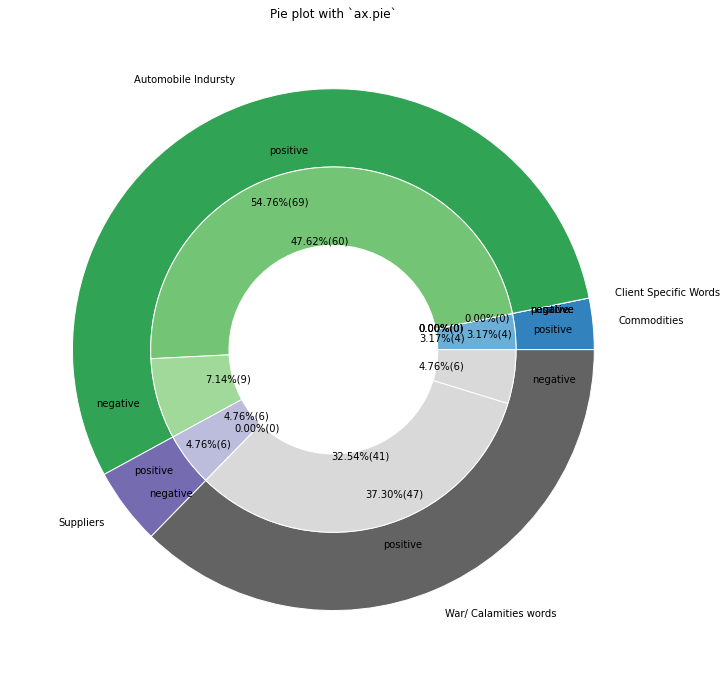

In [101]:
fig, ax = plt.subplots(figsize=(24,12))
size = 0.3

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(5)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10,14,15,20,21])

ax.pie(outer.values, radius=1,colors=outer_colors,
       labels=outer.index,
       autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*outer.values.sum()),
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(inner_size, radius=1-size, colors=inner_colors,
       labels = inner_label,autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*sum(inner_size)),
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Textblob sentiment analysis')
plt.show()

,Commodities,Client Specific Words,Automobile Indursty,Suppliers,War/ Calamities words
positive,4,0,60,6,41
negative,0,0,9,0,6


['positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'negative']

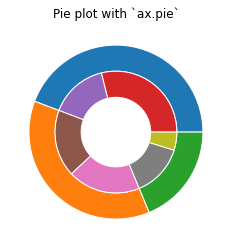

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

# cmap = plt.colormaps["tab20c"]
# outer_colors = cmap(np.arange(3)*4)
# inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [9]:
# from collections import Counter

# tag_count = Counter(list(df_article['tag'])).most_common()
# subtag_count = Counter(list(df_article['subtag'])).most_common()
# business_tags = Counter(df_article[df_article['tag']=='Business']['tag_list'].sum()).most_common()